In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime

# Cleaning Drought Data

From Drought Monitor: https://droughtmonitor.unl.edu/Data.aspx 

Alternatively, try to find the data we want from here: https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx

> Please note, shapefiles prior to 2004 have been digitized from the image archive. Preliminary error
> analysis indicates that the digitized datasets have a horizontal error of approximately 4 miles when
> compared to authored datasets. For comparison, the drought impacts line in a georeferenced image is
> approximately 12 miles wide

# Cleaning Earthquake Data

From the US Geological Survey.
Alternatively, try to find the data we want from here: https://earthquake.usgs.gov/earthquakes/search/

Explanation of fields: https://earthquake.usgs.gov/data/comcat/data-eventterms.php 

# Cleaning Tornado Data
From the Storm Prediction Center: https://www.spc.noaa.gov/gis/svrgis/ 

Explanation of fields:
https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf 

In [2]:
cwd = os.getcwd()
date_format = "%Y-%m-%d"
TORNADO_PATH = os.path.join(cwd, "../..", "data/tornadoes/US_tornadoes_2000_2022.csv")
TORNADO_SHAPEFILE = os.path.join(cwd, "../..", "data/geographic/US_tornadoes_1950_2022/US_tornadoes_1950_2022.shp")
COUNTIES_PATH = os.path.join(cwd, "../..", "data/counties/2018_counties.csv")
COUNTIES_SHAPEFILE = os.path.join(cwd, "../..", "data/geographic/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")
INTERSECTION_PATH = os.path.join(cwd, "../..", "data/tornado_county_intersections.csv")

In [3]:
def cost_by_year(data, year):
    # lower_date = datetime(year=year)
    # upper_date = datetime(year=year+1)
    filtered = data.loc[data["yr"]==year]
    costs = [loss for loss in filtered["loss"]]
    print(costs)
    return sum(costs)

def load_tornado_data():
    tornados_gpd = gpd.read_file(TORNADO_SHAPEFILE)
    #add a tornado id column because OID disappears(?)
    tornados_gpd["tornado_id"] = tornados_gpd.index

    filtered_by_cost = tornados_gpd.loc[tornados_gpd["loss"]>=1]

    dates = [datetime.strptime(time,date_format) for time in filtered_by_cost["date"]]
    lats = np.array([[slat for slat in filtered_by_cost["slat"]], [elat for elat in filtered_by_cost["elat"]]]).T
    lons = np.array([[slon for slon in filtered_by_cost["slon"]], [elon for elon in filtered_by_cost["elon"]]]).T
    cost = [loss for loss in filtered_by_cost["loss"]]
    # print(lats)
    # print(lons)
    # print(cost)
    print(cost_by_year(tornados_gpd,2002))
    return tornados_gpd

def load_county_data():
    counties_gpd = gpd.read_file(COUNTIES_SHAPEFILE)
    print(counties_gpd.head())
    return counties_gpd

def intersect(tornado_data, county_data, save=False):
    #convert to web mercator projection
    tornado_data.to_crs(epsg=4326, inplace=True)
    county_data.to_crs(epsg=4326, inplace=True)

    # Perform the spatial join
    intersection_df = gpd.sjoin(tornado_data, county_data, how='inner', op='intersects', lsuffix='tornado', rsuffix='county')

    # Reset the index of the resulting DataFrame
    intersection_df = intersection_df.reset_index(drop=True)

    # Print the resulting DataFrame
    print(intersection_df)

    #reset the index to avoid the Int64Index error
    intersection_df["row_id"] = intersection_df.index + 1
    intersection_df.reset_index(drop=True, inplace=True)
    intersection_df.set_index("row_id", inplace = True)

    if save:
        #save to csv
        pd.DataFrame(intersection_df.assign(geometry=intersection_df["geometry"].apply(lambda p: p.wkt))).to_csv(path_or_buf=INTERSECTION_PATH)
    
    return intersection_df

In [4]:
tornados_gpd = load_tornado_data()
counties_gpd = load_county_data()

[0.0, 0.0, 0.75, 0.01, 0.0, 3.0, 0.02, 0.0, 0.001, 0.05, 0.5, 0.02, 0.0, 75.0, 10.0, 0.0, 0.18, 0.06, 0.1, 0.31, 0.21, 5.0, 0.03, 0.75, 0.01, 0.09, 0.03, 0.03, 0.01, 0.03, 0.5, 0.03, 1.0, 0.03, 0.03, 0.01, 0.03, 0.01, 0.03, 0.01, 0.03, 0.003, 0.003, 0.01, 0.003, 0.001, 0.01, 0.01, 0.0, 0.01, 0.01, 0.02, 0.01, 0.15, 0.07, 0.1, 0.0, 1.5, 3.0, 0.0, 0.1, 0.0, 0.07, 0.5, 0.25, 0.004, 0.001, 0.01, 0.12, 30.0, 0.53, 0.05, 0.85, 12.1, 0.01, 0.0, 12.8, 0.33, 1.3, 0.5, 13.5, 1.3, 0.2, 2.35, 0.01, 0.001, 0.85, 0.02, 0.11, 0.01, 0.0, 0.15, 0.13, 0.05, 17.0, 0.25, 3.2, 1.0, 60.2, 0.0, 0.1, 0.14, 0.33, 0.14, 0.0, 0.97, 0.02, 0.0, 0.21, 0.07, 4.3, 0.2, 0.1, 0.01, 0.0, 0.04, 0.4, 0.5, 0.8, 0.4, 0.04, 1.2, 1.5, 7.6, 0.07, 0.04, 0.002, 0.25, 0.0, 0.0, 0.0, 0.0, 0.02, 0.51, 0.1, 0.03, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.15, 3.0, 0.2, 0.01, 0.5, 6.63, 0.75, 0.5, 0.03, 0.11, 0.4, 0.0, 0.05, 0.0, 0.5, 0.0, 0.0, 0.05, 0.14, 0.002, 0.54, 0.0, 0.07, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0

           om    yr  mo  dy        date      time  tz  st  stf  stn  ...  \
0         192  1950  10   1  1950-10-01  21:00:00   3  OK   40   23  ...   
1         193  1950  10   9  1950-10-09  02:15:00   3  NC   37    9  ...   
2         195  1950  11  20  1950-11-20  02:20:00   3  KY   21    1  ...   
3         196  1950  11  20  1950-11-20  04:00:00   3  KY   21    2  ...   
4         197  1950  11  20  1950-11-20  07:30:00   3  MS   28   14  ...   
...       ...   ...  ..  ..         ...       ...  ..  ..  ...  ...  ...   
78444  621922  2022   9  28  2022-09-28  13:32:00   3  FL   12    0  ...   
78445  621923  2022   9  30  2022-09-30  10:25:00   3  NC   37    0  ...   
78446  621924  2022   9  30  2022-09-30  13:22:00   3  NC   37    0  ...   
78447  621900  2022   9   4  2022-09-04  15:44:00   3  OH   39    0  ...   
78448  621901  2022   9   9  2022-09-09  23:21:00   3  SC   45    0  ...   

       index_county  STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID  \
0           

c:\Users\kmorhun\Documents\disasters_and_politics\.conda\Lib\site-packages\geopandas\geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\Users\kmorhun\Documents\disasters_and_politics\.conda\Lib\site-packages\geopandas\geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


<Axes: >

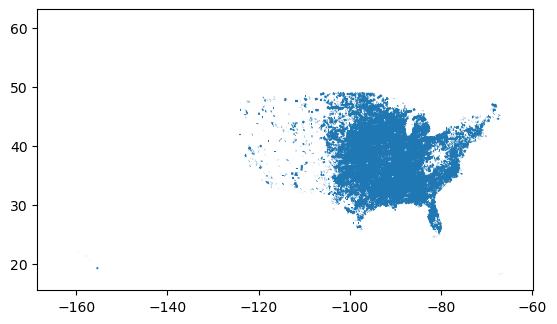

In [5]:
intersection_df = intersect(tornados_gpd, counties_gpd, save=True)
intersection_df.plot()

In [42]:
#testing if the intersection actually worked (check manually on QGIS)
counties_per_tornado = intersection_df[["tornado_id", "date", "time"]].value_counts()
print(counties_per_tornado)

tornadoes_per_county = intersection_df["GEOID"].value_counts()
print(tornadoes_per_county)

#based on a few manual checks, it seems good!

tornado_id  date        time    
11100       1969-04-18  06:15:00    14
66437       2021-12-10  20:54:00    13
802         1953-03-22  15:00:00    12
12411       1971-02-21  16:00:00    12
15289       1974-04-03  15:45:00    11
                                    ..
24511       1984-06-05  20:30:00     1
24512       1984-06-05  22:20:00     1
24513       1984-06-05  22:23:00     1
24514       1984-06-05  23:30:00     1
68700       2022-09-09  23:21:00     1
Name: count, Length: 68313, dtype: int64
GEOID
08123    288
48201    248
08121    183
12099    181
08001    172
        ... 
54109      1
51790      1
51775      1
72063      1
54069      1
Name: count, Length: 3057, dtype: int64


### BROKEN: trying to get percent of tornado path that is in a county

In [6]:
# This doesn't work because spatial join doesn't modify the geometry column. It just takes the geometry column from the left dataframe.

# intersection_df['tornado_length_in_county'] = intersection_df['geometry'].length
# num_zero_lengths_in_counties = (intersection_df['tornado_length_in_county'] == 0).sum()
# print(num_zero_lengths_in_counties)

# num_zero_lengths = (intersection_df['len'] == 0).sum()
# print(num_zero_lengths)

# intersection_df['county_coverage'] = intersection_df['tornado_length_in_county'] / intersection_df['len']

In [31]:
from shapely.geometry import Polygon, MultiPolygon
print(tornados_gpd.geom_type.unique())
print(counties_gpd.geom_type.unique())

# set the counties geometry to just be multipolygons
counties_gpd_modified = counties_gpd.copy(deep=True)
counties_gpd_modified['geometry'] = counties_gpd_modified['geometry'].apply(lambda geom: MultiPolygon([geom]) if geom.geom_type == 'Polygon' else geom)
print(counties_gpd_modified.geom_type.unique())

# buffer the tornados to make them polygons and set the tornados geometry to just be multipolygons
tornados_gpd_modified = tornados_gpd.copy(deep=True)
tornados_gpd_modified['geometry'] = tornados_gpd_modified['geometry'].buffer(0.01)
tornados_gpd_modified['geometry'] = tornados_gpd_modified['geometry'].apply(lambda x: Polygon(x.exterior.coords))
tornados_gpd_modified['geometry'] = tornados_gpd_modified['geometry'].apply(lambda geom: MultiPolygon([geom]) if geom.geom_type == 'Polygon' else geom)
print(tornados_gpd_modified.geom_type.unique())


['LineString']
['Polygon' 'MultiPolygon']
['MultiPolygon']


c:\Users\kmorhun\Documents\disasters_and_politics\.conda\Lib\site-packages\geopandas\geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
C:\Users\kmorhun\AppData\Local\Temp\ipykernel_22576\1220936040.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tornados_gpd_modified['geometry'] = tornados_gpd_modified['geometry'].buffer(0.01)
c:\Users\kmorhun\Documents\disasters_and_politics\.conda\Lib\site-packages\geopandas\geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().

['MultiPolygon']


c:\Users\kmorhun\Documents\disasters_and_politics\.conda\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

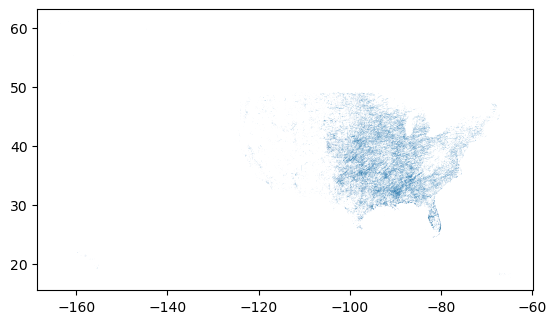

In [33]:
tornados_gpd_modified.plot()

In [39]:
#testing all sorts of things that might make overlay go wrong

#same geometry type
print(tornados_gpd_modified.geom_type.unique())
print(counties_gpd_modified.geom_type.unique())

#same crs
print(tornados_gpd_modified.crs)
print(counties_gpd_modified.crs)

#not empty
print(tornados_gpd_modified.empty)
print(counties_gpd_modified.empty)

#no invalid geometries
invalid_geoms_gdf1 = tornados_gpd_modified[~tornados_gpd_modified.geometry.is_valid]
print("Invalid Geometries in tornados_gpd_modified:", invalid_geoms_gdf1)
invalid_geoms_gdf2 = counties_gpd_modified[~counties_gpd_modified.geometry.is_valid]
print("Invalid Geometries in tornados_gpd_modified:", invalid_geoms_gdf2)

['MultiPolygon']
['MultiPolygon']
epsg:4326
EPSG:4326
False
False
Invalid Geometries in tornados_gpd_modified: Empty GeoDataFrame
Columns: [om, yr, mo, dy, date, time, tz, st, stf, stn, mag, inj, fat, loss, closs, slat, slon, elat, elon, len, wid, fc, geometry, tornado_id]
Index: []

[0 rows x 24 columns]
Invalid Geometries in tornados_gpd_modified: Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, COUNTYNS, AFFGEOID, GEOID, NAME, LSAD, ALAND, AWATER, geometry]
Index: []


In [41]:
#broken :(
tc_overlay = gpd.overlay(tornados_gpd_modified, counties_gpd_modified, how='intersection')
tc_overlay.plot()

AttributeError: 'GeoSeries' object has no attribute 'iteritems'